# **_kWh Energy Forecasting Project_**

## **_1 - Importing Libraries_**

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.dates as mdates
from datetime import datetime
import prophet as Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ARIMA, SARIMAX
import pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## **_2 - Features_**

In [379]:
def features(df):
    daily_data = pd.read_csv('daily - Sheet1.csv')

    daily_data = daily_data.rename(columns={'Start': 'date'})


    daily_data['date'] = (pd.to_datetime(daily_data['date'], format='%m/%d/%Y %I:%M:%S %p').dt.normalize())

    daily_data['day'] = daily_data['date'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_data['day'] = pd.Categorical(daily_data['day'], categories=day_order)

    daily_data['day_number'] = daily_data['date'].dt.day_of_week
    weekdays = daily_data[daily_data['day_number'] < 5]
    weekends = daily_data[daily_data['day_number'] >= 5]

    daily_data['month'] = daily_data['date'].dt.month_name()
    daily_data['month_number'] = daily_data['date'].dt.month  # <-- Added this line
    daily_data['weekday'] = (daily_data['day_number'] < 5).astype(int)

    daily_data = daily_data.set_index('date', inplace=False)
    return daily_data


In [380]:
df = features('daily - Sheet1.csv')
df.head()

,kWh,day,day_number,month,month_number,weekday
date,,,,,,
2025-06-01,5.05,Sunday,6,June,6,0
2025-06-02,6.86,Monday,0,June,6,1
2025-06-03,9.10,Tuesday,1,June,6,1
2025-06-04,7.32,Wednesday,2,June,6,1
2025-06-05,12.88,Thursday,3,June,6,1


## **_3 - Exploratory Data Analysis_**

#### **_3.1 - kWh Time Series Graph_**

<Figure size 1800x600 with 0 Axes>

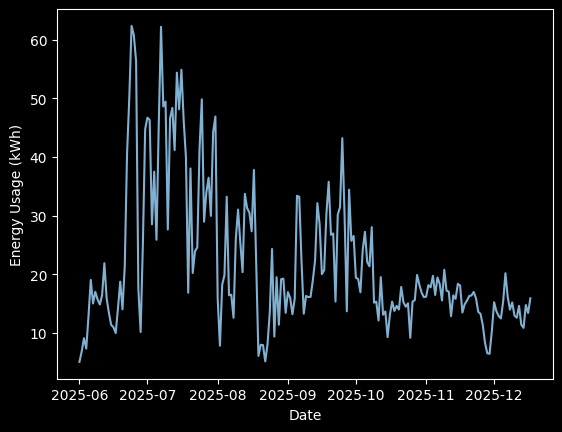

<Figure size 1800x600 with 0 Axes>

In [386]:
sns.lineplot(df['kWh'], color = sns.color_palette()[4])
plt.xlabel('Date')
plt.ylabel('Energy Usage (kWh)')
plt.figure(figsize=(18,6))



#### _3.2 - Average kWh Per Day_

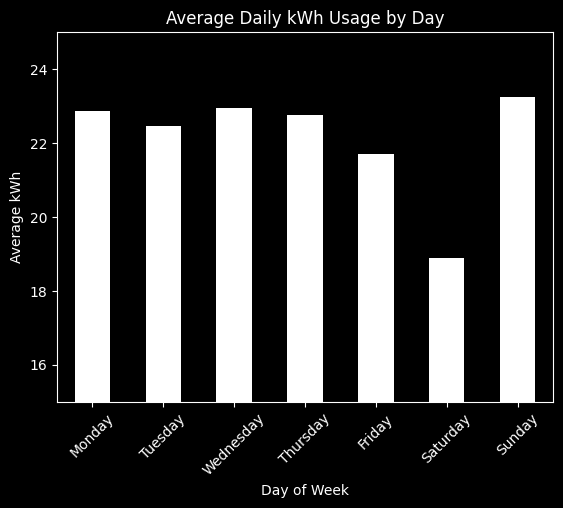

day
Monday       22.879310
Tuesday      22.468621
Wednesday    22.941379
Thursday     22.770357
Friday       21.705714
Saturday     18.884643
Sunday       23.262069
Name: kWh, dtype: float64

In [387]:
df.groupby('day', observed = True)['kWh'].mean().plot(kind='bar', color='white')
plt.ylabel('Average kWh')
plt.xlabel('Day of Week')
plt.title('Average Daily kWh Usage by Day')
plt.xticks(rotation=45)
plt.ylim(15,25)
plt.show()
(df.groupby('day', observed = True)['kWh'].mean())


#### **_3.3 - Average kWh by Month_**

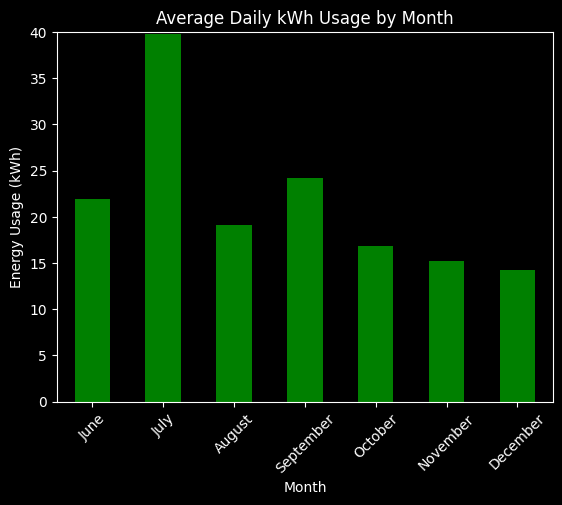

In [389]:
month_order = [
    'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

(
    df.groupby('month')['kWh']
      .mean()
      .reindex(month_order)
      .plot(kind='bar', color='Green')
)

plt.ylabel('Energy Usage (kWh)')
plt.xlabel('Month')
plt.title('Average Daily kWh Usage by Month')
plt.xticks(rotation=45)
plt.ylim(0, 40)
plt.show()


#### _**3.4 - Weekends vs Weekdays**_

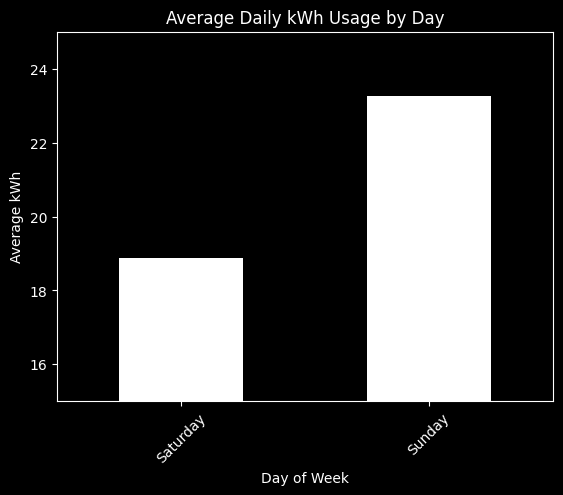

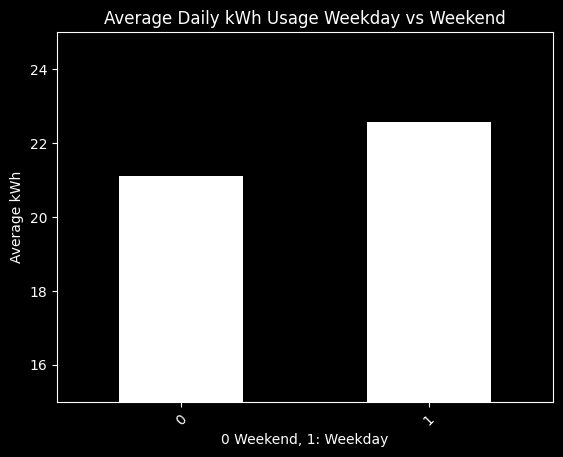

In [418]:
weekends = df[df['day_number'] > 4]
weekends.groupby('day', observed = True)['kWh'].mean().plot(kind='bar', color='white')
plt.ylabel('Average kWh')
plt.xlabel('Day of Week')
plt.title('Average Daily kWh Usage by Day')
plt.xticks(rotation=45)
plt.ylim(15,25)
plt.show()


(df.groupby('weekday', observed = True)['kWh'].mean()).plot(kind='bar', color='white')
plt.ylabel('Average kWh')
plt.xlabel('0 Weekend, 1: Weekday')
plt.title('Average Daily kWh Usage Weekday vs Weekend')
plt.xticks(rotation=45)
plt.ylim(15,25)
plt.show()

## _4 - Train / Split_

In [399]:
X = df.drop(columns=['kWh', 'day','month'])   # all real predictors
y = df['kWh'].values

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_test  = X.iloc[split_point:]

y_train = y[:split_point]
y_test  = y[split_point:]


## _5 - Arima_

#### **_5.1 - ADF Test for Stationarity_**

In [400]:
adf_test = adfuller(df['kWh'].values)
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.886002
p-value: 0.047000


#### **_5.2 - Autocorrelation Function_**

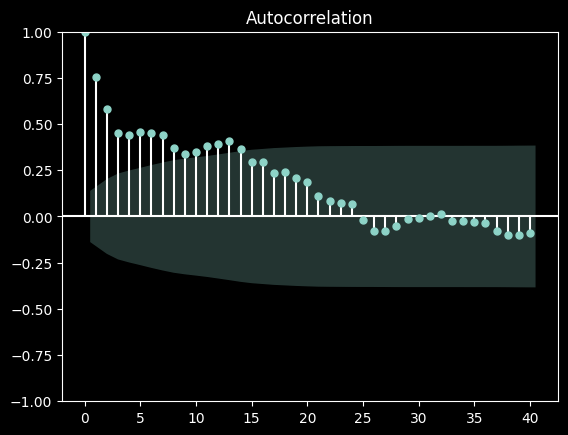

In [401]:
plot_acf(df['kWh'].values, lags=40)
plt.show()

#### **_5.3 - Partial Autocorrelation Function_**

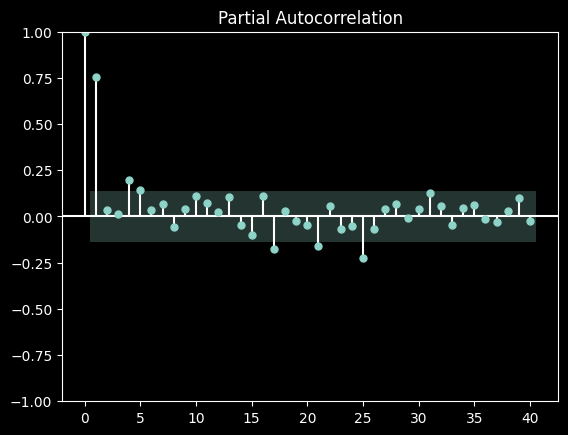

In [402]:
plot_pacf(df['kWh'].values, lags=40)
plt.show()

#### **_5.4 - Auto Arima_**

In [404]:
from pmdarima import auto_arima

optimal_model = auto_arima(y_train, start_p=0, start_q=0,
                           test='adf',
                           max_p=3, max_q=3,
                           m=1,
                           d=None,
                           seasonal=True,
                           start_P=0,
                           D=0,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(optimal_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1173.051, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1171.196, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1169.277, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1171.063, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1153.876, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1154.521, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1155.066, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1158.878, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1171.193, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1151.910, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1167.299, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1169.212, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1152.564, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [421]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.statespace.sarimax")
model = SARIMAX(y_train, order=(1,1, 1))
model_fit = model.fit()



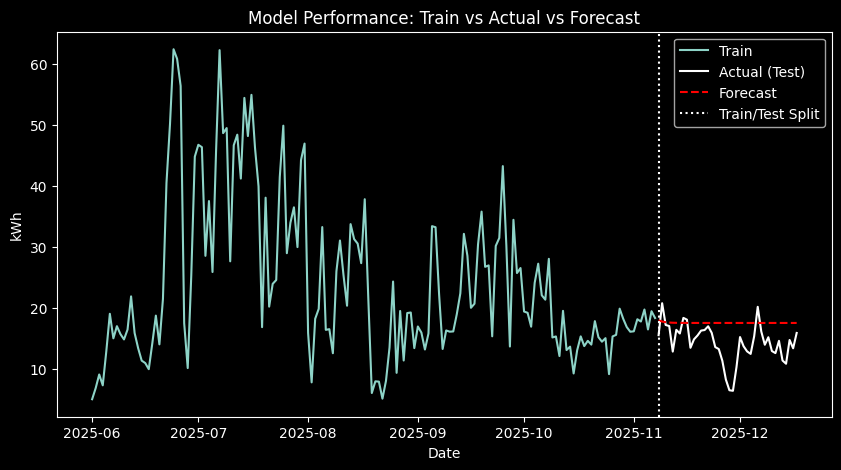

Test RMSE: 4.459848125927703
Test MAE: 3.592938531099827
Naive RMSE: 5.07309939780407


In [431]:
n_test = len(y_test)
forecast_values = model_fit.forecast(steps=n_test)

test_index = df.index[-n_test:]

forecast = pd.Series(forecast_values, index=test_index)
y_test_series = pd.Series(y_test, index=test_index)


plt.figure(figsize=(10, 5))

plt.plot(df.index[:-n_test], df['kWh'].iloc[:-n_test], label='Train')
plt.plot(test_index, y_test_series, label='Actual (Test)', color = 'white')
plt.plot(test_index, forecast, label='Forecast', linestyle='--', color = 'red')

plt.axvline(df.index[-n_test], linestyle=':', label='Train/Test Split')

plt.title('Model Performance: Train vs Actual vs Forecast')
plt.ylabel('kWh')
plt.xlabel('Date')
plt.legend()
plt.show()


from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

print("Test RMSE:", root_mean_squared_error(y_test_series, forecast))
print("Test MAE:", mean_absolute_error(y_test_series, forecast))

naive_forecast = np.repeat(y_train[-1], len(y_test))

print("Naive RMSE:",
      root_mean_squared_error(y_test, naive_forecast))


## **_6.0 Regression Trees_**

Root Mean Squared Error: 4.1153


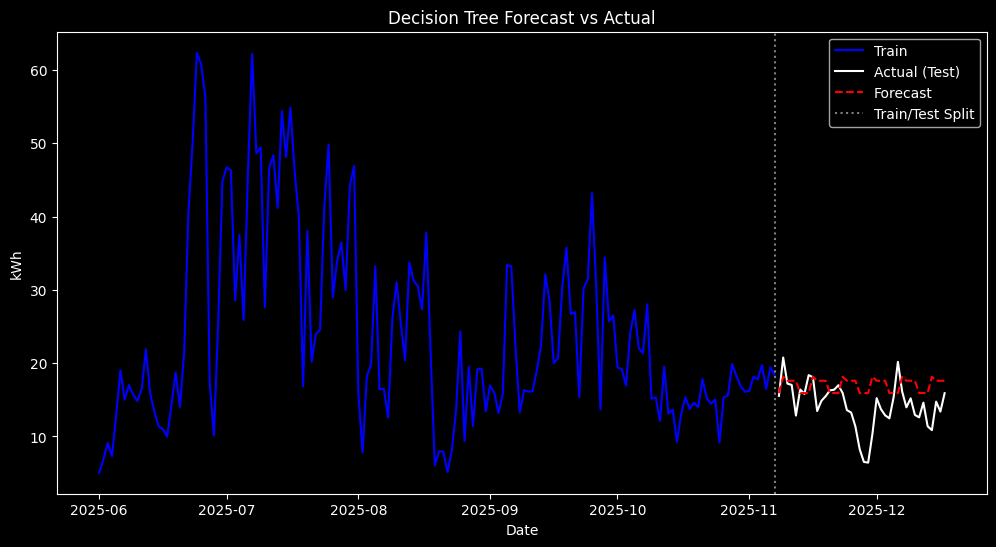

In [429]:
y_train_series = pd.Series(y_train, index=df.index[:split_point])
y_test_series  = pd.Series(y_test,  index=df.index[split_point:])

regressor = DecisionTreeRegressor(max_depth=4, random_state=42)
regressor.fit(X_train, y_train_series)
y_pred = regressor.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {mse:.4f}")

plt.figure(figsize=(12,6))


plt.plot(y_train_series.index, y_train_series, label='Train', color='blue')


plt.plot(y_test_series.index, y_test_series, label='Actual (Test)', color='White')


plt.plot(y_test_series.index, y_pred, label='Forecast', color='red', linestyle='--')


plt.axvline(y_train_series.index[-1], color='gray', linestyle=':', label='Train/Test Split')

plt.title('Decision Tree Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()


## **_7.0 - Random Forrest_**

Random Forest RMSE: 4.5074
Random Forest MAE: 3.6762

Feature Importance:
month_number    0.771722
day_number      0.215202
weekday         0.013076
dtype: float64


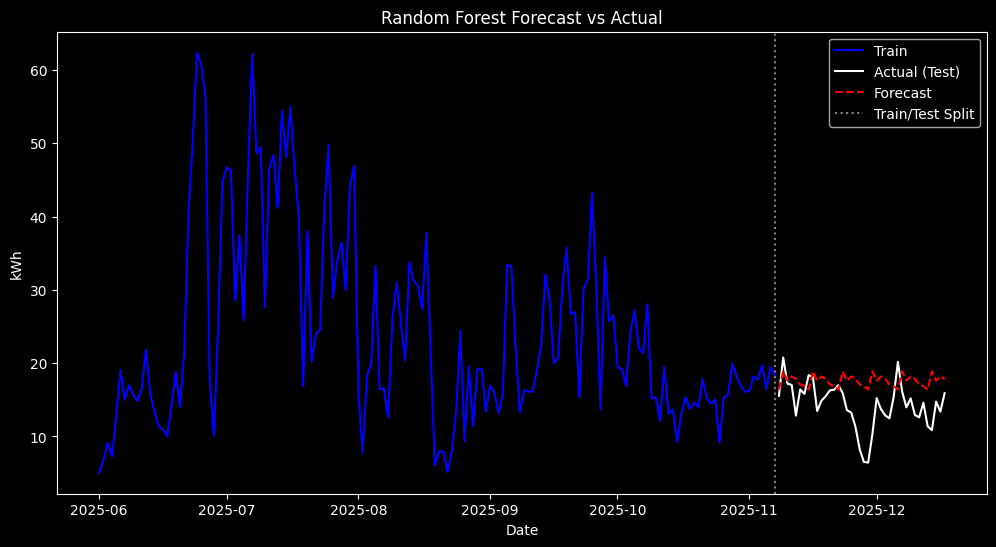

In [424]:
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    random_state=42
)
rf_regressor.fit(X_train, y_train_series)

y_pred = rf_regressor.predict(X_test)

#Metrics
rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest MAE: {mae:.4f}")

feature_importance = pd.Series(
    rf_regressor.feature_importances_,
    index=X.columns
).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(12,6))

plt.plot(y_train_series.index, y_train_series, label='Train', color='blue')
plt.plot(y_test_series.index, y_test_series, label='Actual (Test)', color='white')
plt.plot(y_test_series.index, y_pred, label='Forecast', color='red', linestyle='--')
plt.axvline(y_train_series.index[-1], color='gray', linestyle=':', label='Train/Test Split')

plt.title('Random Forest Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

## **_8.0 - Prophet_**

15:50:01 - cmdstanpy - INFO - Chain [1] start processing
15:50:01 - cmdstanpy - INFO - Chain [1] done processing


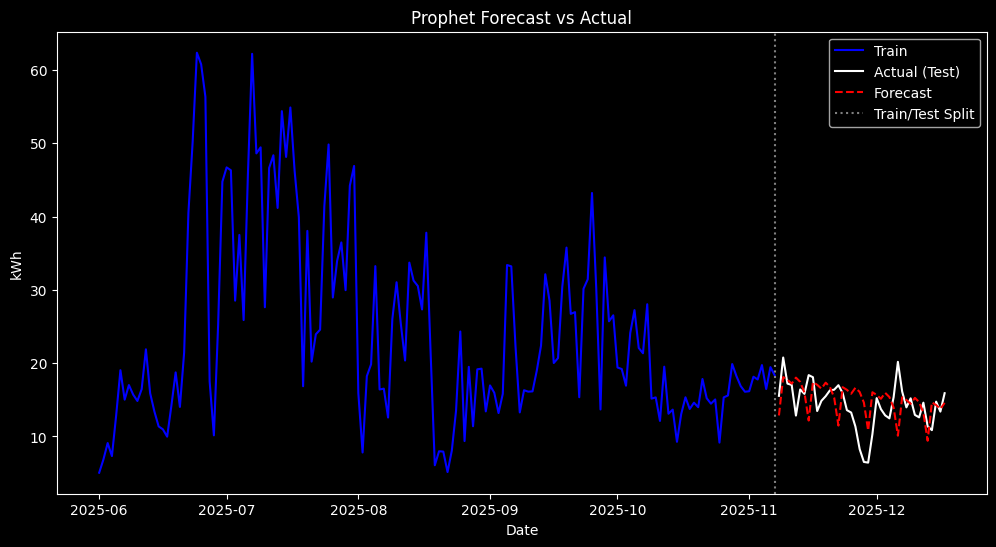

Prophet RMSE: 3.5739
Prophet MAE: 2.6618


In [425]:
prophet_df = df.reset_index()[['date', 'kWh']].rename(columns={'date':'ds', 'kWh':'y'})


split_point = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:split_point]
test_df  = prophet_df.iloc[split_point:]


model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_df)


future = test_df[['ds']].copy()
forecast = model.predict(future)


plt.figure(figsize=(12,6))
plt.plot(train_df['ds'], train_df['y'], label='Train', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Actual (Test)', color='White')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')
plt.axvline(train_df['ds'].iloc[-1], color='gray', linestyle=':', label='Train/Test Split')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

#Metrics
rmse = root_mean_squared_error(test_df['y'], forecast['yhat'])
mae  = mean_absolute_error(test_df['y'], forecast['yhat'])
print(f"Prophet RMSE: {rmse:.4f}")
print(f"Prophet MAE: {mae:.4f}")


## **_9.0 - Holt Winters Exponential Smoothing_**

Holt-Winters RMSE: 3.5696
Holt-Winters MAE: 2.5214


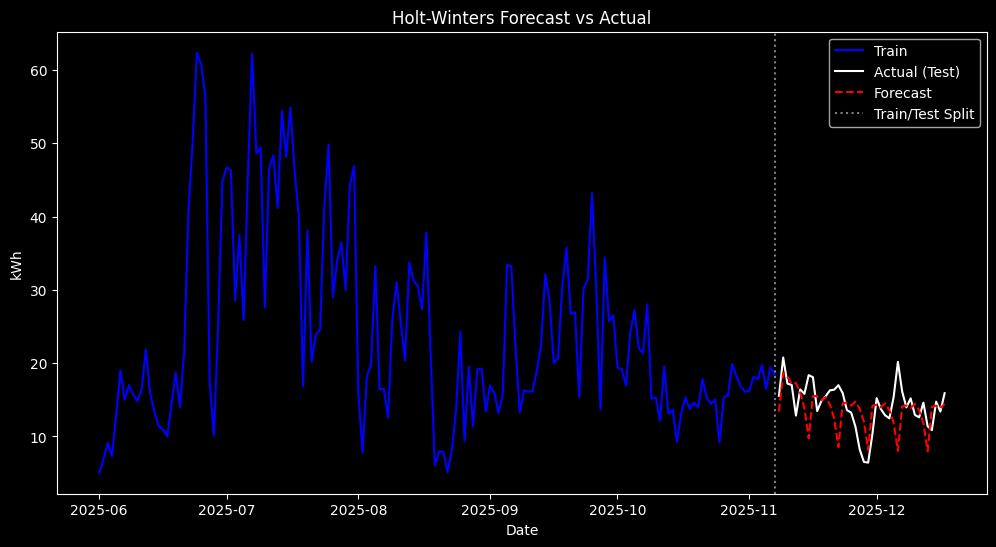

In [428]:
y_train_series = y_train_series.asfreq('D')
y_test_series  = y_test_series.asfreq('D')

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


hw_model = ExponentialSmoothing(
    y_train_series,
    trend='multiplicative',
    seasonal='additive',
    seasonal_periods=7
).fit()


y_pred = hw_model.forecast(len(y_test_series))

rmse = root_mean_squared_error(y_test_series, y_pred)
mae  = mean_absolute_error(y_test_series, y_pred)
print(f"Holt-Winters RMSE: {rmse:.4f}")
print(f"Holt-Winters MAE: {mae:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_train_series.index, y_train_series, label='Train', color='blue')
plt.plot(y_test_series.index, y_test_series, label='Actual (Test)', color='White')
plt.plot(y_test_series.index, y_pred, label='Forecast', color='red', linestyle='--')
plt.axvline(y_train_series.index[-1], color='gray', linestyle=':', label='Train/Test Split')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()
